In [1]:
%reload_ext autoreload
%autoreload 2

In [24]:
import numpy as np
import torch
import matplotlib.pyplot as pl
import seaborn as sns
import ot
import ot.plot
import matplotlib.pyplot as plt

from linear_solver import UOT_W
import sys

sys.path.append('./ot_mmd/')
from mmdot import solve_apgd
from utils_mmd import kernel


In [30]:
def make_data_1d(expe,n_samples,device='cpu'):        
    if expe == "bimodal":
        xs = np.concatenate((np.random.normal(-0, 1, int(n_samples/2)),np.random.normal(10, 1, int(n_samples/2))))
        xt = np.random.normal(-10, 1, n_samples)
    
    X = torch.from_numpy(xs).to(device)
    Y = torch.from_numpy(xt).to(device)
    X = X.float()
    Y = Y.float()
    return X, Y

In [31]:
np.random.seed(1)
X, Y = make_data_1d("bimodal",100)
n, m = X.shape[0],Y.shape[0]
a, b = torch.ones((n,))/n, torch.ones((m,))/m
C = ot.dist(X[:,None],Y[:,None], metric = 'euclidean')

# KL, L1 and MMD penalties for lambda values giving rise of $\pi_1$ mass equal to 0.5. For the OT penalties, we look for the lambda values that gives $|supp(\pi_1)| = 0.5$


In [70]:
n = 100

print("transported mass:")

P_l2 = ot.unbalanced.mm_unbalanced(a, b, C, 750, div='l2')
pi1_l2 = P_l2@torch.ones(m)
pi2_l2 = (P_l2.T)@torch.ones(n)
print(f"- L2 penalty: {torch.sum(P_l2):.2f}")

P_kl = ot.unbalanced.mm_unbalanced(a, b, C, 9.7, div='kl')
pi1_kl = P_kl@torch.ones(m)
pi2_kl = (P_kl.T)@torch.ones(n)
print(f"- KL penalty: {torch.sum(P_kl):.2f}")

P_l1 = ot.partial.partial_wasserstein(a, b, C, 0.5)
pi1_l1 = P_l1@torch.ones(m)
pi2_l1 = (P_l1.T)@torch.ones(n)
print(f"- TV penalty: {torch.sum(P_l1):.2f}")

Kx=kernel(X[:, None].clone().detach(),sigma=5)
Ky=kernel(Y[:, None].clone().detach(),sigma=5)
G = {1: Kx, 2: Ky}
lam=7.325
P_MMD, _ = solve_apgd(C.clone().detach().float(), G, 
                      v = {1: a.clone().detach().float(), 2: b.clone().detach().float()}, 
                      max_itr=1000, lda=lam, case="unb")
P_MMD = P_MMD.numpy()
pi1_mmd = P_MMD@np.ones(n)
pi2_mmd = (P_MMD.T)@np.ones(n)
print(f"- MMD penalty: {np.sum(P_MMD):.2f}")

overall_p = 2
Cx, Cy = torch.cdist(X[:, None],X[:, None], p = overall_p), torch.cdist(Y[:, None],Y[:, None], p = overall_p)
Cx, Cy = Cx**overall_p, Cy**overall_p

P_W, Qx, Qy = UOT_W(torch.ones((n,))/n, torch.ones((n,))/n, C, lam=.33, Cx=Cx, Cy=Cy, solver="CLARABEL", innerplan = True)
pi1_w = P_W@np.ones(n)
pi2_w = (P_W.T)@np.ones(n)
print(f"- OT penalty: {np.sum(P_W):.2f}")
print(f"+ support of $\pi_1$: {(np.sum(pi1_w > 1e-5))/100:.2f}")

transported mass:
- L2 penalty: 0.50
- KL penalty: 0.50
- TV penalty: 0.50
- MMD penalty: 0.50
- OT penalty: 1.00
+ support of $\pi_1$: 0.50


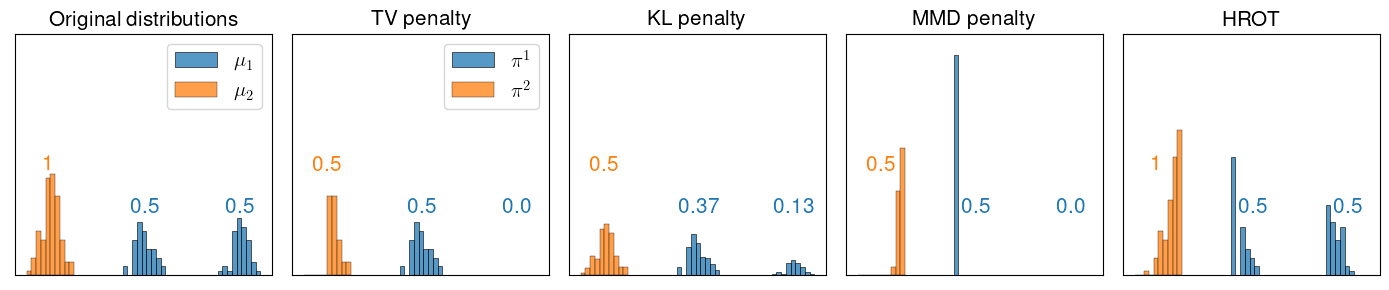

In [77]:
pl.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": "Helvetica",
})

pl.figure(2, (14, 3))

#-------original distributions
pl.subplot(1, 5, 1)

kde=False
sns.histplot(x=X, kde=kde,label="$\mu_1$",binwidth=.5,weights=a,kde_kws=dict(bw_adjust=.5))
sns.histplot(x=Y, kde=kde,label="$\mu_2$",binwidth=.5,weights=b,kde_kws=dict(bw_adjust=.5))
pl.text(-10,0.25, "1",c="C1",alpha=1,ha="center",va="center",fontsize = 15)
pl.text(0,0.155, "0.5",c="C0",alpha=1,ha="center",va="center",fontsize = 15)
pl.text(10,0.155, "0.5",c="C0",alpha=1,ha="center",va="center",fontsize = 15)
#pl.text(-9.8, 2.5, "1",c="C1",alpha=1,ha="center",va="center",fontsize = 15)
pl.xticks([])
pl.yticks([])
pl.ylabel("")
pl.ylim(0,0.55)
pl.title("Original distributions", fontsize = 15)
pl.legend(fontsize = 15)

#-------L2 penalty
# pl.subplot(1, 5, 2)
# kde=False
# sns.histplot(x=X, kde=kde,label="$\pi_1$",binwidth=.5,weights=pi1_l2,kde_kws=dict(bw_adjust=.5))
# sns.histplot(x=Y, kde=kde,label="$\pi_2$",binwidth=.5,weights=pi2_l2,kde_kws=dict(bw_adjust=.5))
# mass1 = np.round(torch.sum(pi2_l2).numpy(),2)
# mass2 = np.round(torch.sum(pi1_l2[ :50]).numpy(),2)
# mass3 = np.round(torch.sum(pi1_l2[ 50:]).numpy(),2)
# pl.text(-10,0.25, str(mass1),c="C1",alpha=1,ha="center",va="center",fontsize = 15)
# pl.text(0,0.155, str(mass2),c="C0",alpha=1,ha="center",va="center",fontsize = 15)
# pl.text(10,0.155, str(mass3),c="C0",alpha=1,ha="center",va="center",fontsize = 15)
# pl.xticks([])
# pl.yticks([])
# pl.ylabel("")
# pl.ylim(0,0.35)
# pl.legend()
# pl.title("L2 penalty", fontsize = 15)

#-------KL penalty
pl.subplot(1, 5, 3)
kde=False
sns.histplot(x=X, kde=kde,label="$\pi_1$",binwidth=.5,weights=pi1_kl,kde_kws=dict(bw_adjust=.5))
sns.histplot(x=Y, kde=kde,label="$\pi_2$",binwidth=.5,weights=pi2_kl,kde_kws=dict(bw_adjust=.5))
mass1 = np.round(torch.sum(pi2_kl).numpy(),2)
mass2 = np.round(torch.sum(pi1_kl[ :50]).numpy(),2)
mass3 = np.round(torch.sum(pi1_kl[ 50:]).numpy(),2)
pl.text(-10,0.25, str(mass1),c="C1",alpha=1,ha="center",va="center",fontsize = 15)
pl.text(0,0.155, str(mass2),c="C0",alpha=1,ha="center",va="center",fontsize = 15)
pl.text(10,0.155, str(mass3),c="C0",alpha=1,ha="center",va="center",fontsize = 15)
pl.xticks([])
pl.yticks([])
pl.ylabel("")
pl.ylim(0,0.55)
pl.title("KL penalty", fontsize = 15)

#-------TV penalty
pl.subplot(1, 5, 2)
kde=False
sns.histplot(x=X, kde=kde,label="$\pi^1$",binwidth=.5,weights=pi1_l1,kde_kws=dict(bw_adjust=.5))
sns.histplot(x=Y, kde=kde,label="$\pi^2$",binwidth=.5,weights=pi2_l1,kde_kws=dict(bw_adjust=.5))
mass1 = np.round(torch.sum(pi2_l1).numpy(),2)
mass2 = np.round(torch.sum(pi1_l1[ :50]).numpy(),2)
mass3 = np.round(torch.sum(pi1_l1[ 50:]).numpy(),2)
pl.text(-10,0.25, str(mass1),c="C1",alpha=1,ha="center",va="center",fontsize = 15)
pl.text(0,0.155, str(mass2),c="C0",alpha=1,ha="center",va="center",fontsize = 15)
pl.text(10,0.155, str(mass3),c="C0",alpha=1,ha="center",va="center",fontsize = 15)
pl.xticks([])
pl.yticks([])
pl.ylabel("")
pl.ylim(0,0.55)
pl.legend(fontsize = 15)
pl.title("TV penalty", fontsize = 15)

#-------MMD penalty
pl.subplot(1, 5, 4)
kde=False
sns.histplot(x=X, kde=kde,label="$\pi^1$",binwidth=.5,weights=pi1_mmd,kde_kws=dict(bw_adjust=.5))
sns.histplot(x=Y, kde=kde,label="$\pi^2$",binwidth=.5,weights=pi2_mmd,kde_kws=dict(bw_adjust=.5))
mass1 = np.round(torch.sum(pi2_l1).numpy(),2)
mass2 = np.round(torch.sum(pi1_l1[ :50]).numpy(),2)
mass3 = np.round(torch.sum(pi1_l1[ 50:]).numpy(),2)
pl.text(-10,0.25, str(mass1),c="C1",alpha=1,ha="center",va="center",fontsize = 15)
pl.text(0,0.155, str(mass2),c="C0",alpha=1,ha="center",va="center",fontsize = 15)
pl.text(10,0.155, str(mass3),c="C0",alpha=1,ha="center",va="center",fontsize = 15)
pl.xticks([])
pl.yticks([])
pl.ylabel("")
pl.ylim(0,0.55)
pl.title("MMD penalty", fontsize = 15)


#-------OT penalty
pl.subplot(1, 5, 5)

kde=False
sns.histplot(x=X, kde=kde,label="$\pi^1$", binwidth=.5, weights=pi1_w, kde_kws=dict(bw_adjust=.5))
sns.histplot(x=Y, kde=kde,label="$\pi^2$", binwidth=.5, weights=pi2_w, kde_kws=dict(bw_adjust=.5))

pl.text(-10,0.25, "1", c="C1", alpha=1, ha="center", va="center", fontsize = 15)
pl.text(0,0.155, "0.5", c="C0", alpha=1, ha="center", va="center", fontsize = 15)
pl.text(10,0.155, "0.5", c="C0", alpha=1, ha="center", va="center", fontsize = 15)
pl.xticks([])
pl.yticks([])
pl.ylabel("")
pl.ylim(0,1)
pl.title("HROT", fontsize = 15)
pl.ylim(0,0.55)
pl.tight_layout()

pl.savefig("figure2.pdf",bbox_inches='tight')

pl.show()
